In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd

Using TensorFlow backend.


In [3]:
np.random.seed(0)

In [4]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [5]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"

In [6]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

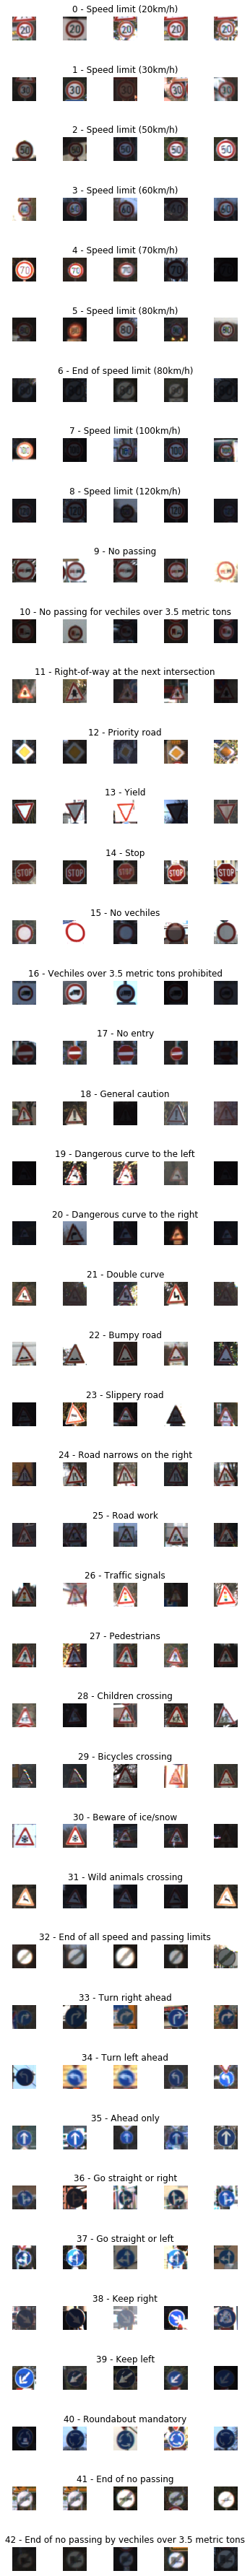

In [7]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row['SignName'])
            num_of_samples.append(len(x_selected))

Text(0, 0.5, 'Number of images')

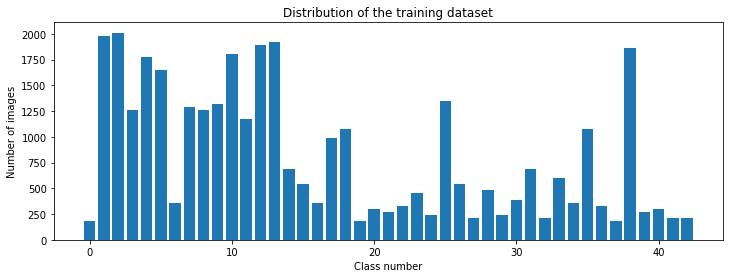

In [8]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


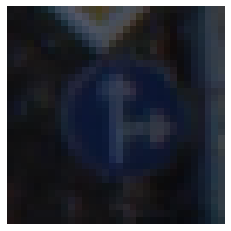

In [9]:
import cv2
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [10]:
# Convert the image to grayscale to get rid of the depth
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


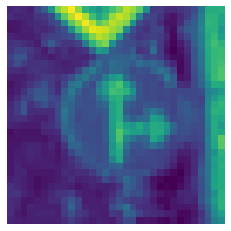

In [11]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [12]:
# Histogram Equalization
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(-0.5, 31.5, 31.5, -0.5)

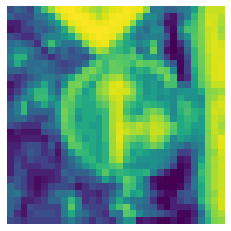

In [13]:
img = equalize(img)
plt.imshow(img)
plt.axis('off')

In [14]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [15]:
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

(-0.5, 31.5, 31.5, -0.5)

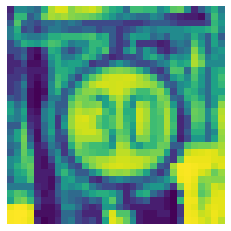

In [16]:
plt.imshow(X_train[random.randint(0, len(X_train-1))])
plt.axis('off')

In [17]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [18]:
# Modifying images to get more data samples
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(X_train)

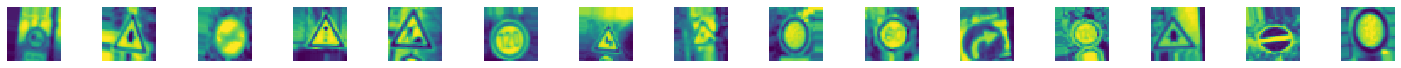

In [19]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32,32))
    axs[i].axis('off')

In [20]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [21]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [23]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 354s 177ms/step - loss: 1.2615 - accuracy: 0.6294 - val_loss: 0.0981 - val_accuracy: 0.9730
Epoch 2/10
2000/2000 [==============================] - 365s 183ms/step - loss: 0.3955 - accuracy: 0.8759 - val_loss: 0.0643 - val_accuracy: 0.9798
Epoch 3/10
2000/2000 [==============================] - 358s 179ms/step - loss: 0.2714 - accuracy: 0.9146 - val_loss: 0.0430 - val_accuracy: 0.9862
Epoch 4/10
2000/2000 [==============================] - 363s 182ms/step - loss: 0.2226 - accuracy: 0.9309 - val_loss: 0.0317 - val_accuracy: 0.9889
Epoch 5/10
2000/2000 [==============================] - 320s 160ms/step - loss: 0.1928 - accuracy: 0.9399 - val_loss: 0.0267 - val_accuracy: 0.9918
Epoch 6/10
2000/2000 [==============================] - 297s 148ms/step - loss: 0.1697 - accuracy: 0.9473 - val_loss: 0.0355 - val_accuracy: 0.9893
Epoch 7/10
2000/2000 [==============================] - 289s 145ms/step - loss: 0.1575 - accuracy: 0.9509 - val_

Text(0.5, 0, 'Epoch')

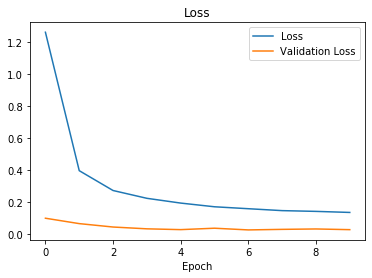

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

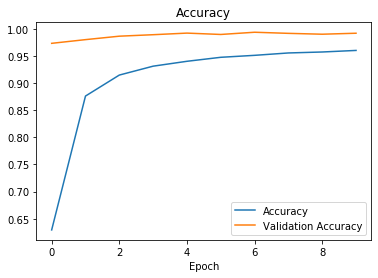

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.11112503370991668
Test Accuracy: 0.96856689453125


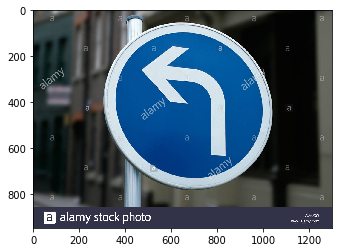

In [27]:
#Fetch image
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


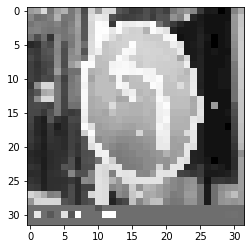

In [28]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [29]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [30]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [34]
